In [1]:
from pyspark.sql import SparkSession, SQLContext
import numpy as np
from scipy.stats import beta 
import os
import sys
import pyspark

sys.path.insert(1, './utils')
sys.path.insert(1, './initializers')
sys.path.insert(1, './epi_models')
sys.path.insert(1, './scoring_models')
sys.path.insert(1, './edge_estimation_models')

from Initializer101 import Initializer101
import Simple_SIR as ssir
import ScoringWalker as sw
import StochasticEdgeEstimator as see

sys.path.insert(1, '.')
import SparkDependencyInjection as sdi
import PandiSimConfigInjection as pci
import PandiNetwork as pn
import PandiSim as ps

In [2]:
spark = SparkSession.builder.master('local')\
    .config(key = "spark.default.parallelism", value = 4)\
    .config(key = "spark.driver.memory", value = "6g")\
    .config(key = "spark.executor.memory", value = "6g")\
    .config(key = "spark.memory.fraction", value = "0.9")\
    .getOrCreate()
sc = spark.sparkContext
sc.setCheckpointDir("hdfs://namenode:9000/rddch")
sqlc = SQLContext(sc)

In [3]:
sdi.SparkDependencyInjection.set_spark(spark).set_spark_context(sc)
pci.PandiSimConfigInjection.set_write_to("d_pandisim")

PandiSimConfigInjection.PandiSimConfigInjection

In [4]:
N = 20

In [5]:
sir = ssir.Simple_SIR(
    inits = {'S':0.8, 'I':0.2, 'R':0}, 
    params = {'beta':0.45, 'gamma':0.05, 'N':N, 't_end':20, 'step_size':1}
)

In [6]:
sir.interact()

interactive(children=(FloatSlider(value=0.25, description='beta', max=0.5, step=0.01), FloatSlider(value=0.25,…

In [7]:
edge_est = see.StochasticEdgeEstimator(
    network = None,
    params = {'SDF': 70, 'alpha': 30, 'beta': 75}
)

In [8]:
edge_est.interact()

interactive(children=(IntSlider(value=100, description='alpha', max=200, step=5), IntSlider(value=50, descript…

In [9]:
sir.run()
dr = sir.current_sotw()[1]
dr
# sir.all_sotw

array([4., 0.])

In [10]:
init = Initializer101(
    nbr_vertices = N, 
    nbr_edges = 9, 
    nbr_infected = int(dr[0]), 
    nbr_recovered = int(dr[1])
)

init.initialize_vertices()
init.initialize_edges(init.vertices)

DataFrame[src: bigint, dst: bigint]

In [11]:
network = init.toPandiNetwork()

+---+---+
|src|dst|
+---+---+
|  1|  8|
| 10|  5|
|  9| 17|
|  3| 16|
|  2| 19|
|  0|  6|
| 13| 18|
| 15| 14|
|  7| 12|
+---+---+

+---+-----+-------------+
| id|score|health_status|
+---+-----+-------------+
|  0|  1.0|          1.0|
|  1|  0.0|          0.0|
|  2|  0.0|          0.0|
|  3|  0.0|          0.0|
|  4|  1.0|          1.0|
|  5|  0.0|          0.0|
|  6|  0.0|          0.0|
|  7|  0.0|          0.0|
|  8|  0.0|          0.0|
|  9|  0.0|          0.0|
| 10|  0.0|          0.0|
| 11|  0.0|          0.0|
| 12|  0.0|          0.0|
| 13|  1.0|          1.0|
| 14|  1.0|          1.0|
| 15|  0.0|          0.0|
| 16|  0.0|          0.0|
| 17|  0.0|          0.0|
| 18|  0.0|          0.0|
| 19|  0.0|          0.0|
+---+-----+-------------+



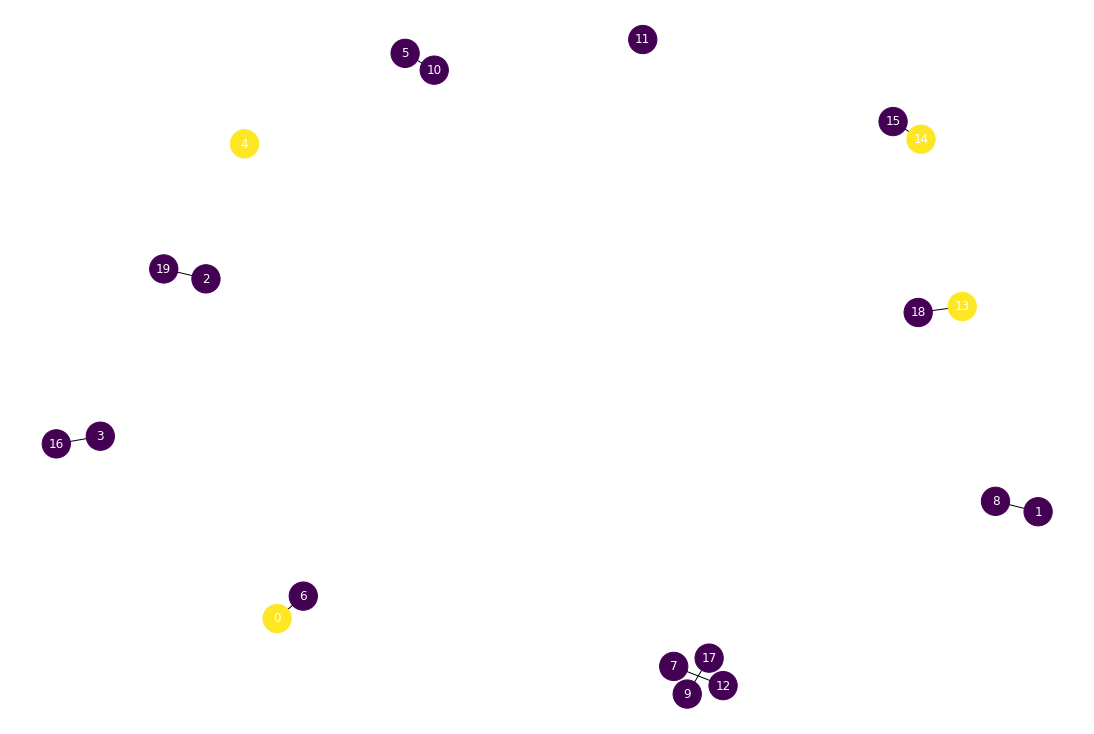

In [12]:
network.interact()

In [13]:
edge_est.network = network

In [14]:
walker = sw.ScoringWalker(
    network, 
    params = {'alpha-scaler':-2, 'walker-steps':3}
)

In [15]:
pandisim = ps.PandiSim(
    network = network, 
    epi_model = sir, 
    scoring_model = walker, 
    edge_model = edge_est, 
    params = {'take_screenshots':False}
)

In [16]:
pandisim.move()

+---+---+
|src|dst|
+---+---+
|  4| 19|
|  3|  5|
|  2| 15|
|  2|  6|
|  3| 14|
|  4|  7|
|  2|  5|
|  3| 13|
|  2| 14|
|  4| 17|
|  2|  9|
|  3| 16|
|  3|  4|
|  3| 15|
|  4| 10|
|  3|  8|
|  3| 19|
|  4|  5|
|  4| 14|
|  3| 18|
+---+---+
only showing top 20 rows

+---+--------------------+-------------+
| id|               score|health_status|
+---+--------------------+-------------+
|  0|                 1.0|          1.0|
|  1|  0.0564888762807492|          0.0|
|  2|  0.0564888762807492|          0.0|
|  3|  0.0564888762807492|          0.0|
|  4|                 1.0|          1.0|
|  5|  0.0564888762807492|          0.0|
|  6|                 1.0|          1.0|
|  7|  0.0564888762807492|          0.0|
|  8|  0.0564888762807492|          0.0|
|  9|  0.0564888762807492|          0.0|
| 10|  0.0564888762807492|          0.0|
| 11|2.847974621404797...|          0.0|
| 12|  0.0564888762807492|          0.0|
| 13|                 1.0|          1.0|
| 14|                 1.0|          1

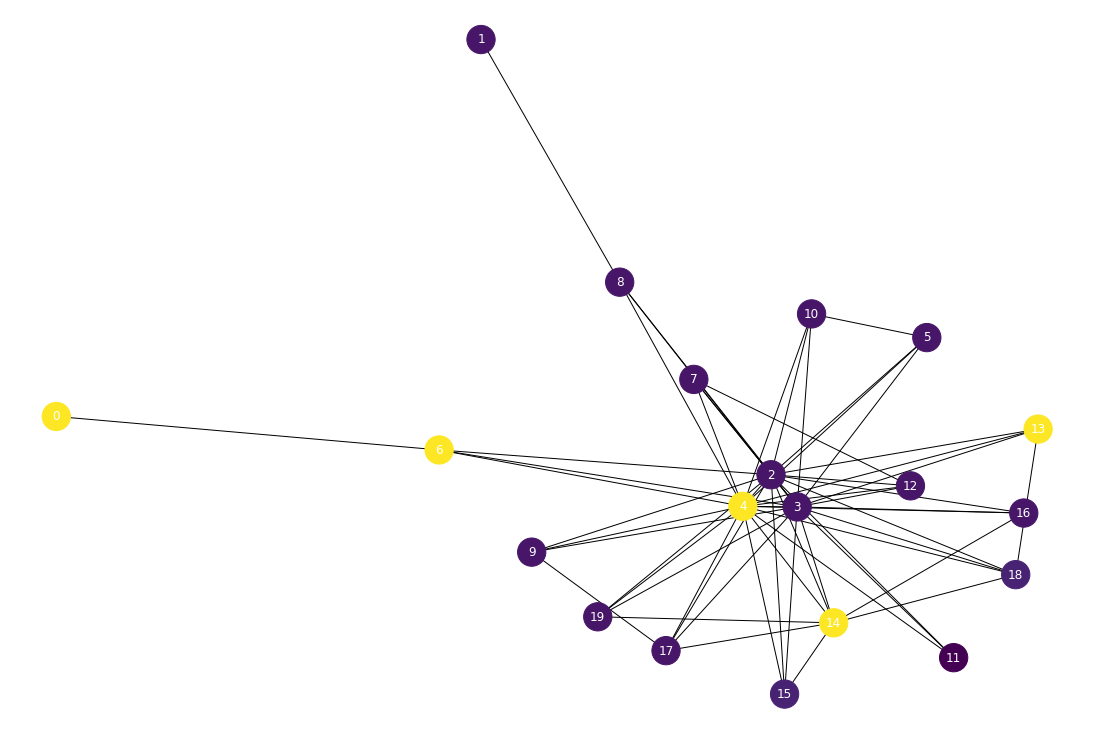

In [17]:
network.interact()

In [ ]:
pandisim.move()

In [ ]:
network.interact()